In [1]:
!nvidia-smi

Mon Dec 11 03:32:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.78       Driver Version: 512.78       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   44C    P8    N/A /  N/A |   1537MiB /  3072MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Mengatur TensorFlow agar tidak mengambil seluruh blok memori GPU sekaligus
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Jika terjadi error, biasanya terjadi karena perintah dijalankan setelah TensorFlow diinisialisasi
        print(e)


In [3]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Activation,Dropout,Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tqdm import tqdm
from sklearn.metrics import f1_score
#config = tf.compat.v1.ConfigProto()
#config.gpu_options.allow_growth = True
#sess = tf.compat.v1.Session(config=config)
#tf.config.experimental.set_memory_growth
print ('Modules loaded')

Modules loaded


In [4]:
def make_dataframes(sdir): 
    filepaths=[]
    labels=[]
    classlist=sorted(os.listdir(sdir) )     
    for klass in classlist:
        classpath=os.path.join(sdir, klass) 
        if os.path.isdir(classpath):
            flist=sorted(os.listdir(classpath)) 
            desc=f'{klass:25s}'
            for f in tqdm(flist, ncols=130,desc=desc, unit='files', colour='blue'):
                fpath=os.path.join(classpath,f)
                filepaths.append(fpath)
                labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    df=pd.concat([Fseries, Lseries], axis=1) 
    train_df, dummy_df=train_test_split(df, train_size=.8, shuffle=True, random_state=123, stratify=df['labels']) 
    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels']) 
    classes=sorted(train_df['labels'].unique())
    class_count=len(classes)
    sample_df=train_df.sample(n=50, replace=False)
    # calculate the average image height and with
    ht=0
    wt=0
    count=0
    for i in range(len(sample_df)):
        fpath=sample_df['filepaths'].iloc[i]
        try:
            img=cv2.imread(fpath)
            h=img.shape[0]
            w=img.shape[1]
            wt +=w
            ht +=h
            count +=1
        except:
            pass
    have=int(ht/count)
    wave=int(wt/count)
    aspect_ratio=have/wave
    print('number of classes in processed dataset= ', class_count)    
    counts=list(train_df['labels'].value_counts()) 
    print(counts[0], type(counts[0]))
    print('the maximum files in any class in train_df is ', max(counts), '  the minimum files in any class in train_df is ', min(counts))
    print('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))  
    print('average image height= ', have, '  average image width= ', wave, ' aspect ratio h/w= ', aspect_ratio)    
    return train_df, test_df, valid_df, classes, class_count

sdir=r'C:\Users\DDYUSUF\ProjectAI\TAD4ELKA\TBC_Dataset'
train_df, test_df, valid_df, classes, class_count=make_dataframes(sdir)

Tuberkulosis             : 100%|███████████████████████████████████████████████████████| 2000/2000 [00:00<00:00, 214159.00files/s]


number of classes in processed dataset=  2
1600 <class 'int'>
the maximum files in any class in train_df is  1600   the minimum files in any class in train_df is  1600
train_df length:  3200   test_df length:  400   valid_df length:  400
average image height=  512   average image width=  512  aspect ratio h/w=  1.0


In [5]:
def make_gens(batch_size, train_df, test_df, valid_df, img_size):
    trgen=ImageDataGenerator()
    t_and_v_gen=ImageDataGenerator()
    msg='{0:70s} for train generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    
    train_gen=trgen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    msg='{0:70s} for valid generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    valid_gen=t_and_v_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=batch_size)
    # for the test_gen we want to calculate the batch size and test steps such that batch_size X test_steps= number of samples in test set
    # this insures that we go through all the sample in the test set exactly once.
    length=len(test_df)
    test_batch_size=20 
    test_steps=int(length/test_batch_size)
    msg='{0:70s} for test generator'.format(' ')
    print(msg, '\r', end='') # prints over on the same line
    test_gen=t_and_v_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size,
                                       class_mode='categorical', color_mode='rgb', shuffle=False, batch_size=test_batch_size)
    # from the generator we can get information we will need later
    classes=list(train_gen.class_indices.keys())
    class_indices=list(train_gen.class_indices.values())
    class_count=len(classes)
    labels=test_gen.labels
    print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps, ' number of classes : ', class_count)
    return train_gen, test_gen, valid_gen, test_steps

img_size=(224,224)
batch_size = 8
train_gen, test_gen, valid_gen, test_steps =make_gens(batch_size, train_df, test_df, valid_df, img_size)

Found 3200 validated image filenames belonging to 2 classes.           for train generator 
Found 400 validated image filenames belonging to 2 classes.            for valid generator 
Found 400 validated image filenames belonging to 2 classes.            for test generator 
test batch size:  20   test steps:  20  number of classes :  2


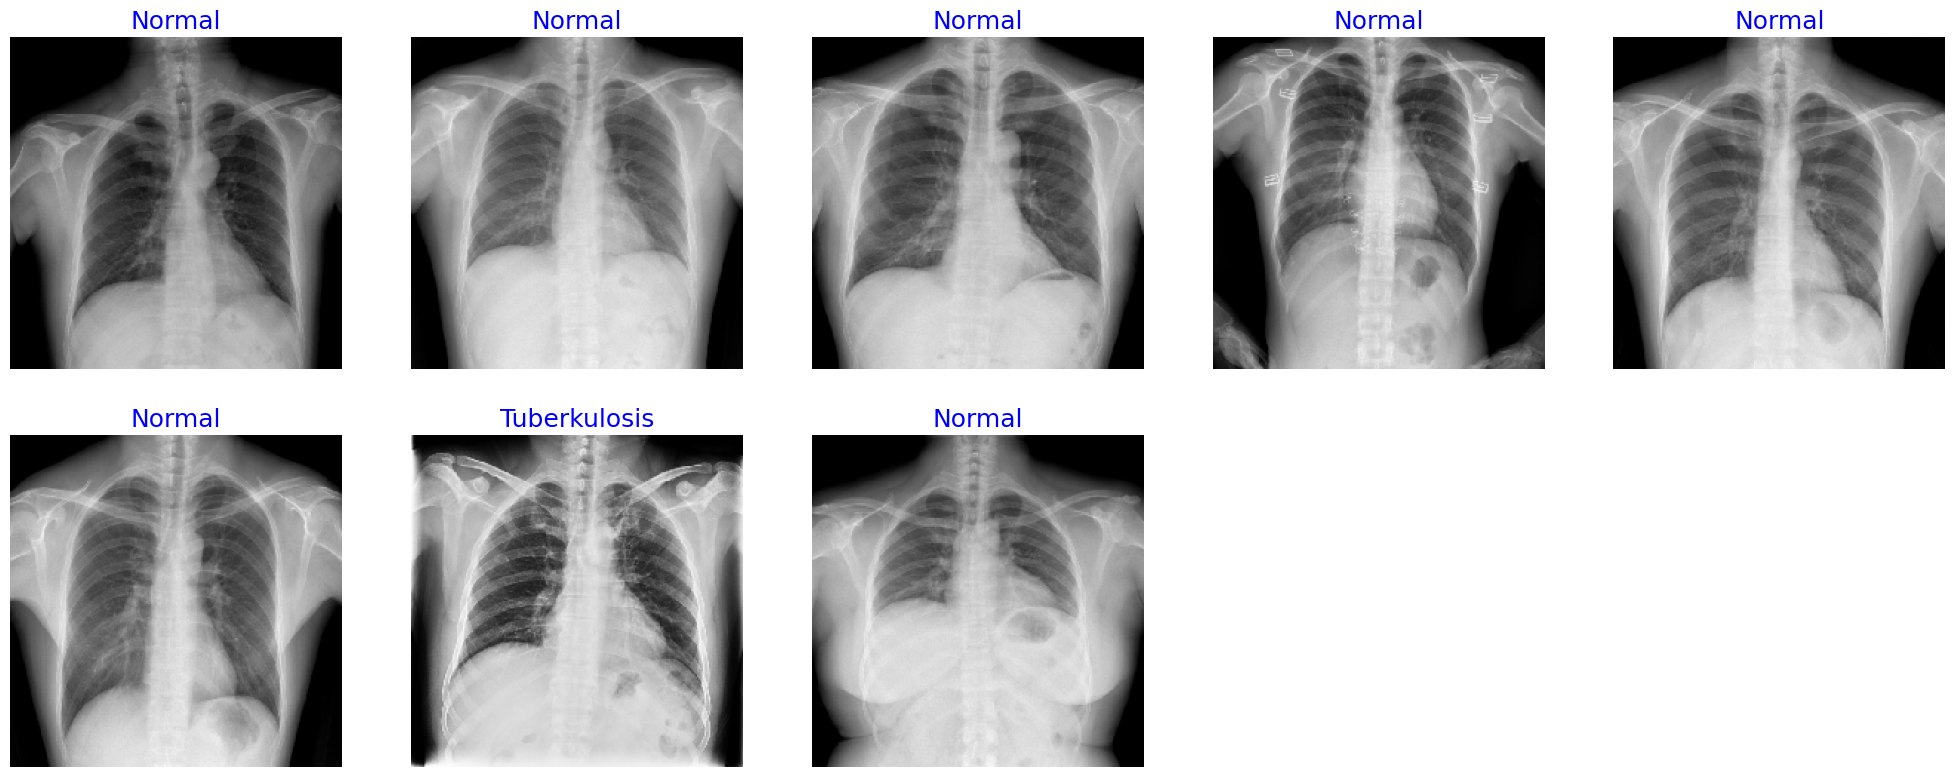

In [6]:
def show_image_samples(gen ):
    t_dict=gen.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(gen) # get a sample batch from the generator 
    plt.figure(figsize=(25, 25))
    length=len(labels)
    if length<25:   #show maximum of 25 images
        r=length
    else:
        r=25
    for i in range(r):        
        plt.subplot(5, 5, i + 1)
        image=images[i] /255       
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=18)
        plt.axis('off')
    plt.show()
    
show_image_samples(train_gen)

In [7]:
def make_model(img_size, lr=.001, mod_num=0):  
    img_shape=(img_size[0], img_size[1], 3)
    normalizer = tf.keras.layers.Rescaling(scale=1/255)
    if mod_num == 0:
        base_model= keras.Sequential([keras.Input(shape=(224,224,3)), normalizer])
        #First Layer
        base_model.add(Conv2D(filters = 16, kernel_size = (3,3), strides = 1, input_shape = img_shape, padding = 'same', activation = 'relu'))
        base_model.add(MaxPooling2D(pool_size = (3,3), strides = 2))
        #Second Layer
        base_model.add(Conv2D(filters = 32, kernel_size = (3,3), strides = 1, padding = 'same',activation = 'relu'))
        base_model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
        #Third Layer
        base_model.add(Conv2D(filters = 64, kernel_size = (3,3), strides = 1, padding = 'same',activation = 'relu'))
        base_model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
        #Fourth Layer
        base_model.add(Conv2D(filters = 128, kernel_size = (3,3), strides = 1, padding = 'same',activation = 'relu'))
        base_model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
        #Five Layer
        base_model.add(Conv2D(filters = 256, kernel_size = (3,3), strides = 1, padding = 'same',activation = 'relu'))
        base_model.add(MaxPooling2D(pool_size = (2,2), strides = 2))
        #Flattening the layers
        base_model.add(Flatten())
        msg='Created Custom CNN model'
        
    elif mod_num == 1:
        base_model=tf.keras.applications.efficientnet.EfficientNetB3(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
        msg='Created EfficientNet B3 model'  
   
    base_model.trainable=False
    x = base_model.output
    x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
    x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = Dropout(rate=.4, seed=123)(x)       
    output = Dense(class_count, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    model.summary()
    model.compile(Adam(learning_rate=.0001), loss='categorical_crossentropy', metrics=['accuracy']) 
    msg=msg + f' with initial learning rate set to {lr}'
    print(msg)
    return model

Custom_CNN = 0
EfficientNetB3 = 1
model=make_model(img_size,.001,EfficientNetB3) # using B3 model by default

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling_1[0][0]']            
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 224, 224, 3)  0           ['normalization[0][0]']      

 block2a_expand_conv (Conv2D)   (None, 112, 112, 14  3456        ['block1b_add[0][0]']            
                                4)                                                                
                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 112, 112, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 112, 112, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 113, 113, 14  0          ['block2a_expand_activation[0][0]
 g2D)     

 ivation)                                                                                         
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 56, 56, 192)  1728       ['block2c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 56, 56, 192)  768        ['block2c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block2c_activation (Activation  (None, 56, 56, 192)  0          ['block2c_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block3b_activation (Activation  (None, 28, 28, 288)  0          ['block3b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3b_se_squeeze (GlobalAver  (None, 288)         0           ['block3b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block3b_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block3b_se_squeeze[0][0]']     
                                                                                                  
 block3b_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block3b_se_reshape[0][0]']     
          

 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 288)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 288)    0           ['block4a_se_squeeze[0][0]']     
                                                                                                  
 block4a_se_reduce (Conv2D)     (None, 1, 1, 12)     3468        ['block4a_se_reshape[0][0]']     
                                                                                                  
 block4a_se_expand (Conv2D)     (None, 1, 1, 288)    3744        ['block4a_se_reduce[0][0]']      
          

                                                                                                  
 block4c_se_excite (Multiply)   (None, 14, 14, 576)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 14, 14, 96)   55296       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_project_bn (BatchNorma  (None, 14, 14, 96)  384         ['block4c_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4c_drop (Dropout)         (None, 14, 14, 96)   0           ['block4c_project_bn[0][0]']     
          

                                                                                                  
 block4e_project_bn (BatchNorma  (None, 14, 14, 96)  384         ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 14, 14, 96)   0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_add (Add)              (None, 14, 14, 96)   0           ['block4e_drop[0][0]',           
                                                                  'block4d_add[0][0]']            
                                                                                                  
 block5a_expand_conv (Conv2D)   (None, 14, 14, 576)  55296       ['block4e_add[0][0]']            
          

                                                                                                  
 block5c_expand_bn (BatchNormal  (None, 14, 14, 816)  3264       ['block5c_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5c_expand_activation (Act  (None, 14, 14, 816)  0          ['block5c_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5c_dwconv (DepthwiseConv2  (None, 14, 14, 816)  20400      ['block5c_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5c_b

 ivation)                                                                                         
                                                                                                  
 block5e_dwconv (DepthwiseConv2  (None, 14, 14, 816)  20400      ['block5e_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5e_bn (BatchNormalization  (None, 14, 14, 816)  3264       ['block5e_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5e_activation (Activation  (None, 14, 14, 816)  0          ['block5e_bn[0][0]']             
 )                                                                                                
          

                                                                                                  
 block6b_activation (Activation  (None, 7, 7, 1392)  0           ['block6b_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block6b_se_squeeze (GlobalAver  (None, 1392)        0           ['block6b_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block6b_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6b_se_squeeze[0][0]']     
                                                                                                  
 block6b_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6b_se_reshape[0][0]']     
          

 agePooling2D)                                                                                    
                                                                                                  
 block6d_se_reshape (Reshape)   (None, 1, 1, 1392)   0           ['block6d_se_squeeze[0][0]']     
                                                                                                  
 block6d_se_reduce (Conv2D)     (None, 1, 1, 58)     80794       ['block6d_se_reshape[0][0]']     
                                                                                                  
 block6d_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6d_se_reduce[0][0]']      
                                                                                                  
 block6d_se_excite (Multiply)   (None, 7, 7, 1392)   0           ['block6d_activation[0][0]',     
                                                                  'block6d_se_expand[0][0]']      
          

                                                                                                  
 block6f_se_expand (Conv2D)     (None, 1, 1, 1392)   82128       ['block6f_se_reduce[0][0]']      
                                                                                                  
 block6f_se_excite (Multiply)   (None, 7, 7, 1392)   0           ['block6f_activation[0][0]',     
                                                                  'block6f_se_expand[0][0]']      
                                                                                                  
 block6f_project_conv (Conv2D)  (None, 7, 7, 232)    322944      ['block6f_se_excite[0][0]']      
                                                                                                  
 block6f_project_bn (BatchNorma  (None, 7, 7, 232)   928         ['block6f_project_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 block7b_drop (Dropout)         (None, 7, 7, 384)    0           ['block7b_project_bn[0][0]']     
                                                                                                  
 block7b_add (Add)              (None, 7, 7, 384)    0           ['block7b_drop[0][0]',           
                                                                  'block7a_project_bn[0][0]']     
                                                                                                  
 top_conv (Conv2D)              (None, 7, 7, 1536)   589824      ['block7b_add[0][0]']            
                                                                                                  
 top_bn (BatchNormalization)    (None, 7, 7, 1536)   6144        ['top_conv[0][0]']               
                                                                                                  
 top_activ

In [8]:
class LR_ASK(keras.callbacks.Callback):
    def __init__ (self, model, epochs,  ask_epoch, dwell=True, factor=.4): # initialization of the callback
        super(LR_ASK, self).__init__()
        self.model=model               
        self.ask_epoch=ask_epoch
        self.epochs=epochs
        self.ask=True # if True query the user on a specified epoch
        self.lowest_vloss=np.inf
        self.lowest_aloss=np.inf
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.best_epoch=1
        self.plist=[]
        self.alist=[]
        self.dwell= dwell
        self.factor=factor
        
    def get_list(self): # define a function to return the list of % validation change
        return self.plist, self.alist
    def on_train_begin(self, logs=None): # this runs on the beginning of training
        if self.ask_epoch == 0: 
            print('you set ask_epoch = 0, ask_epoch will be set to 1', flush=True)
            self.ask_epoch=1
        if self.ask_epoch >= self.epochs: # you are running for epochs but ask_epoch>epochs
            print('ask_epoch >= epochs, will train for ', epochs, ' epochs', flush=True)
            self.ask=False # do not query the user
        if self.epochs == 1:
            self.ask=False # running only for 1 epoch so do not query user
        else:
            msg =f'Training will proceed until epoch {ask_epoch} then you will be asked to' 
            print(msg )
            msg='enter H to halt training or enter an integer for how many more epochs to run then be asked again'
            print(msg)
            if self.dwell:
                msg='learning rate will be automatically adjusted during training'
                print(msg)
        self.start_time= time.time() # set the time at which training started
       
    def on_train_end(self, logs=None):   # runs at the end of training  
        msg=f'loading model with weights from epoch {self.best_epoch}'
        print(msg)
        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        tr_duration=time.time() - self.start_time   # determine how long the training cycle lasted         
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg) # print out training duration time
        
    def on_epoch_end(self, epoch, logs=None):  # method runs on the end of each epoch
        vloss=logs.get('val_loss')  # get the validation loss for this epoch
        aloss=logs.get('loss')
        if epoch >0:
            deltav = self.lowest_vloss- vloss 
            pimprov=(deltav/self.lowest_vloss) * 100 
            self.plist.append(pimprov)
            deltaa=self.lowest_aloss-aloss
            aimprov=(deltaa/self.lowest_aloss) * 100
            self.alist.append(aimprov)
        else:
            pimprov=0.0 
            aimprov=0.0
        if vloss< self.lowest_vloss:
            self.lowest_vloss=vloss
            self.best_weights=self.model.get_weights() # set best weights to model's initial weights
            self.best_epoch=epoch + 1            
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % below lowest loss, saving weights from epoch {str(epoch + 1):3s} as best weights'
            print(msg)
        else: # validation loss increased
            pimprov=abs(pimprov)
            msg=f'\n validation loss of {vloss:7.4f} is {pimprov:7.4f} % above lowest loss of {self.lowest_vloss:7.4f} keeping weights from epoch {str(self.best_epoch)} as best weights'
            print(msg)
            if self.dwell: # if dwell is True when the validation loss increases the learning rate is automatically reduced and model weights are set to best weights
                lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                new_lr=lr * self.factor
                msg=f'learning rate was automatically adjusted from {lr:8.6f} to {new_lr:8.6f}, model weights set to best weights'
                print(msg) 
                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                self.model.set_weights(self.best_weights) # set the weights of the model to the best weights      
                
        if aloss< self.lowest_aloss:
            self.lowest_aloss=aloss        
        if self.ask: # are the conditions right to query the user?
            if epoch + 1 ==self.ask_epoch: # is this epoch the one for quering the user?
                msg='press enter to continue or enter a comment  below '
                print(msg)
                comment=input(' ')
                if comment !='':
                    print(comment)
                msg='\n Enter H to end training or  an integer for the number of additional epochs to run then ask again'
                print(msg) 
                ans=input()
                
                if ans == 'H' or ans =='h' or ans == '0': # quit training for these conditions
                    msg=f'you entered {ans},  Training halted on epoch {epoch+1} due to user input\n'
                    print(msg)
                    self.model.stop_training = True # halt training
                else: # user wants to continue training
                    self.ask_epoch += int(ans)
                    if self.ask_epoch > self.epochs:
                        print('\nYou specified maximum epochs of as ', self.epochs, ' cannot train for ', self.ask_epoch, flush =True)
                    else:
                        
                        msg=f'you entered {ans} Training will continue to epoch {self.ask_epoch}'
                        print(msg) 
                        if self.dwell==False:
                            lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
                            msg=f'current LR is  {lr:8.6f}  hit enter to keep  this LR or enter a new LR'
                            print(msg) 
                            ans=input(' ')
                            if ans =='':
                                msg=f'keeping current LR of {lr:7.5f}'
                                print(msg)
                            else:
                                new_lr=float(ans)
                                tf.keras.backend.set_value(self.model.optimizer.lr, new_lr) # set the learning rate in the optimizer
                                msg=f' changing LR to {ans}'
                                print(msg)

In [9]:
epochs=100
ask_epoch=100
ask=LR_ASK(model, epochs,  ask_epoch)
callbacks=[ask]

In [10]:
history=model.fit(x=train_gen, steps_per_epoch = 400,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
                  shuffle=True,  initial_epoch=0)

ask_epoch >= epochs, will train for  100  epochs
Training will proceed until epoch 100 then you will be asked to
enter H to halt training or enter an integer for how many more epochs to run then be asked again
learning rate will be automatically adjusted during training
Epoch 1/100
400/400 [==============================] - ETA: 0s - loss: 7.2618 - accuracy: 0.8259
 validation loss of  5.9683 is  0.0000 % below lowest loss, saving weights from epoch 1   as best weights
400/400 [==============================] - 71s 140ms/step - loss: 7.2618 - accuracy: 0.8259 - val_loss: 5.9683 - val_accuracy: 0.9600
Epoch 2/100
400/400 [==============================] - ETA: 0s - loss: 5.3744 - accuracy: 0.9044
 validation loss of  4.5488 is 23.7840 % below lowest loss, saving weights from epoch 2   as best weights
400/400 [==============================] - 54s 134ms/step - loss: 5.3744 - accuracy: 0.9044 - val_loss: 4.5488 - val_accuracy: 0.9725
Epoch 3/100
400/400 [==============================] - 

400/400 [==============================] - ETA: 0s - loss: 0.1599 - accuracy: 0.9956
 validation loss of  0.1533 is  0.2546 % above lowest loss of  0.1529 keeping weights from epoch 41 as best weights
learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights
400/400 [==============================] - 54s 134ms/step - loss: 0.1599 - accuracy: 0.9956 - val_loss: 0.1533 - val_accuracy: 0.9900
Epoch 47/100
400/400 [==============================] - ETA: 0s - loss: 0.1647 - accuracy: 0.9928
 validation loss of  0.1528 is  0.0623 % below lowest loss, saving weights from epoch 47  as best weights
400/400 [==============================] - 57s 143ms/step - loss: 0.1647 - accuracy: 0.9928 - val_loss: 0.1528 - val_accuracy: 0.9925
Epoch 48/100
400/400 [==============================] - ETA: 0s - loss: 0.1655 - accuracy: 0.9931
 validation loss of  0.1533 is  0.3697 % above lowest loss of  0.1528 keeping weights from epoch 47 as best weights
learning ra

400/400 [==============================] - 57s 141ms/step - loss: 0.1632 - accuracy: 0.9934 - val_loss: 0.1534 - val_accuracy: 0.9875
Epoch 65/100
400/400 [==============================] - ETA: 0s - loss: 0.1648 - accuracy: 0.9928
 validation loss of  0.1529 is  0.0774 % above lowest loss of  0.1528 keeping weights from epoch 47 as best weights
learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights
400/400 [==============================] - 56s 140ms/step - loss: 0.1648 - accuracy: 0.9928 - val_loss: 0.1529 - val_accuracy: 0.9900
Epoch 66/100
400/400 [==============================] - ETA: 0s - loss: 0.1641 - accuracy: 0.9941
 validation loss of  0.1537 is  0.6182 % above lowest loss of  0.1528 keeping weights from epoch 47 as best weights
learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights
400/400 [==============================] - 56s 140ms/step - loss: 0.1641 - accuracy: 0.9941 - val_lo

Epoch 83/100
400/400 [==============================] - ETA: 0s - loss: 0.1639 - accuracy: 0.9916
 validation loss of  0.1538 is  0.6940 % above lowest loss of  0.1528 keeping weights from epoch 47 as best weights
learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights
400/400 [==============================] - 56s 139ms/step - loss: 0.1639 - accuracy: 0.9916 - val_loss: 0.1538 - val_accuracy: 0.9875
Epoch 84/100
400/400 [==============================] - ETA: 0s - loss: 0.1618 - accuracy: 0.9962
 validation loss of  0.1533 is  0.3633 % above lowest loss of  0.1528 keeping weights from epoch 47 as best weights
learning rate was automatically adjusted from 0.000000 to 0.000000, model weights set to best weights
400/400 [==============================] - 56s 140ms/step - loss: 0.1618 - accuracy: 0.9962 - val_loss: 0.1533 - val_accuracy: 0.9900
Epoch 85/100
400/400 [==============================] - ETA: 0s - loss: 0.1675 - accuracy: 0.9922
 v

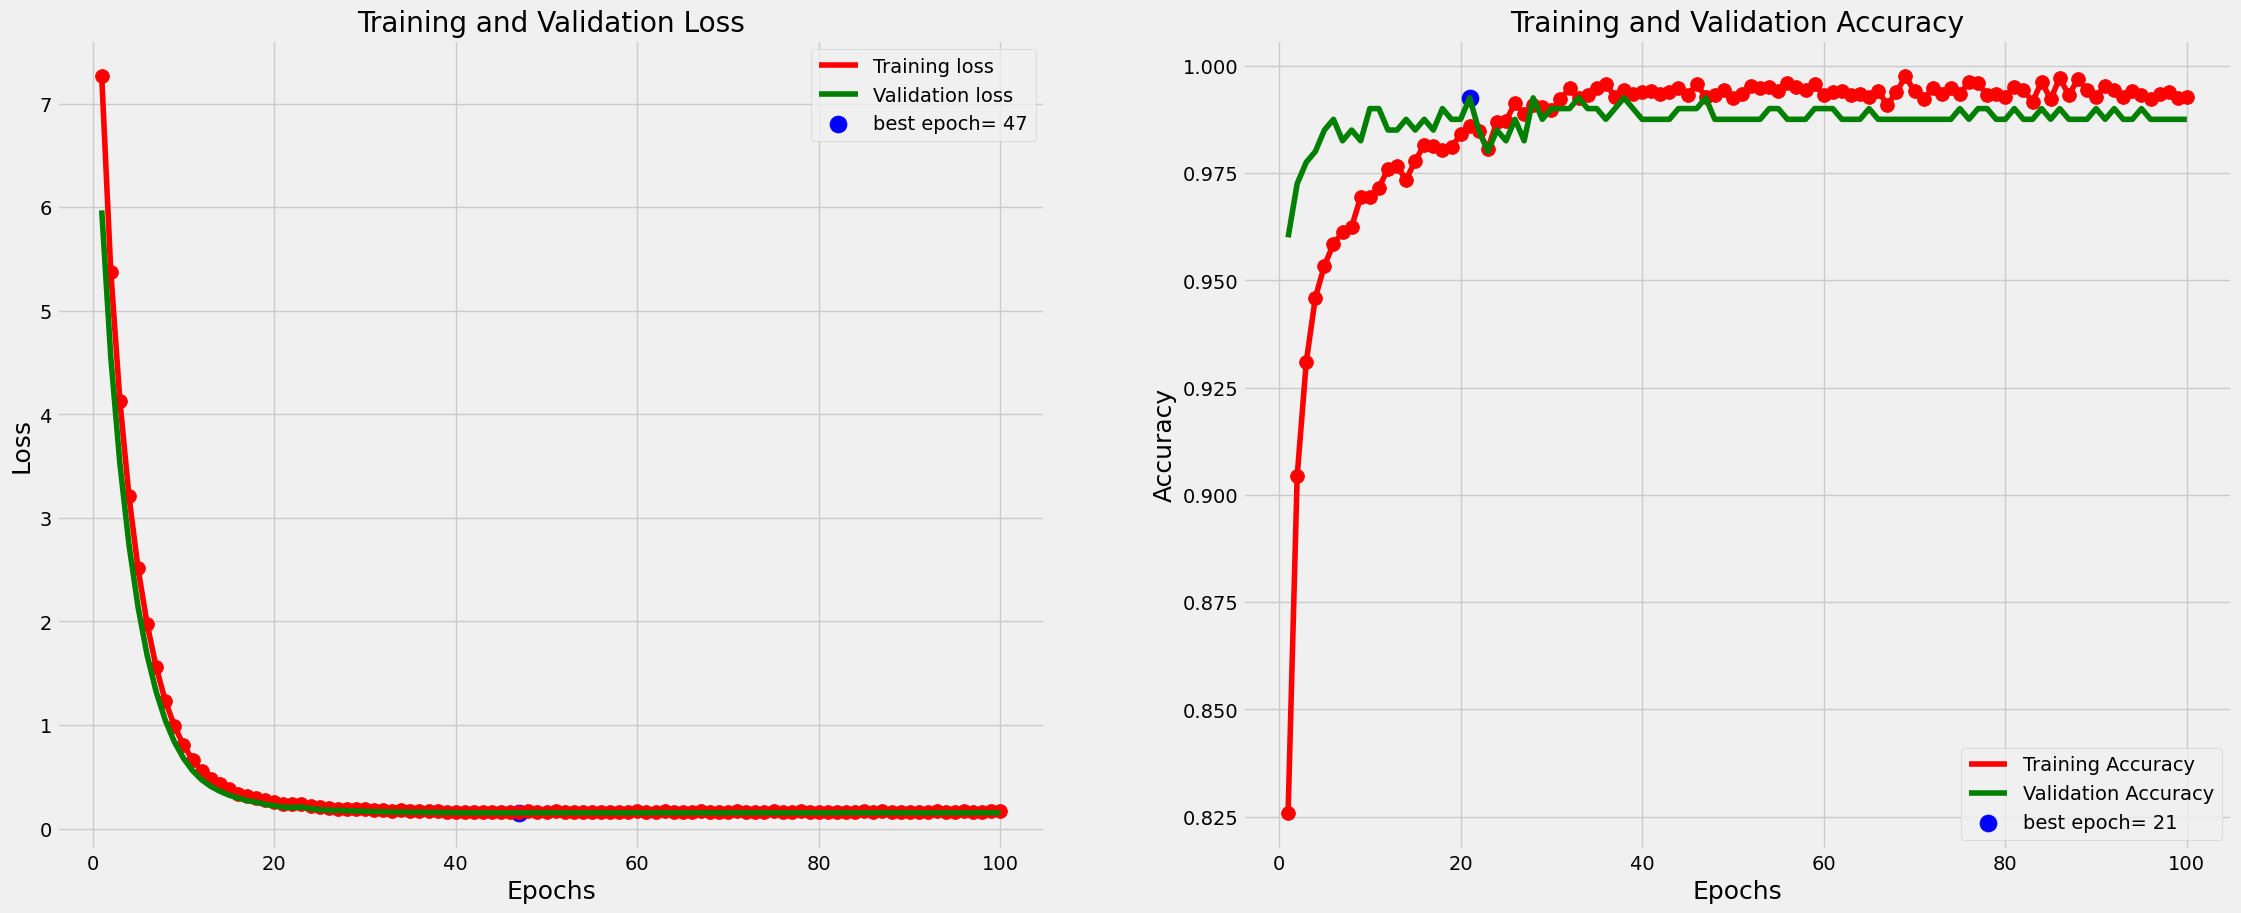

In [11]:
def tr_plot(tr_data, start_epoch):
    #Plot the training and validation data
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(25,10))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].scatter(Epochs, tloss, s=100, c='red')   
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs', fontsize=18)
    axes[0].set_ylabel('Loss', fontsize=18)
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].scatter(Epochs, tacc, s=100, c='red')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs', fontsize=18)
    axes[1].set_ylabel('Accuracy', fontsize=18)
    axes[1].legend()
    plt.tight_layout    
    plt.show()
    return index_loss
    
loss_index=tr_plot(history,0)

20/20 [==============================] - 8s 218ms/step
there were 2 errors in 400 tests for an accuracy of  99.50


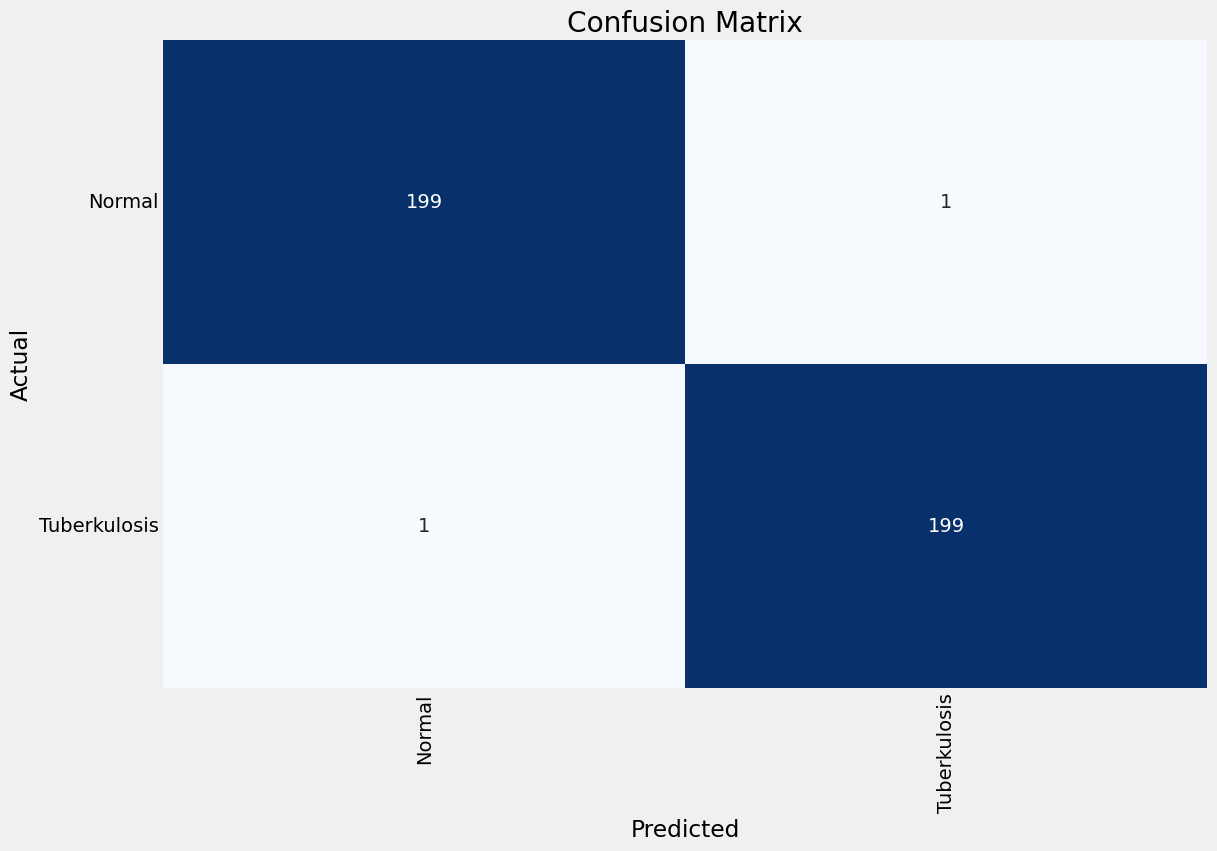

Classification Report:
----------------------
               precision    recall  f1-score   support

      Normal     0.9950    0.9950    0.9950       200
Tuberkulosis     0.9950    0.9950    0.9950       200

    accuracy                         0.9950       400
   macro avg     0.9950    0.9950    0.9950       400
weighted avg     0.9950    0.9950    0.9950       400



In [12]:
def predictor(test_gen):    
    y_pred= []
    error_list=[]
    error_pred_list = []
    y_true=test_gen.labels
    classes=list(test_gen.class_indices.keys())
    class_count=len(classes)
    errors=0
    preds=model.predict(test_gen,steps=test_steps, verbose=1)
    tests=len(preds)    
    for i, p in enumerate(preds):  
        file=test_gen.filenames[i]        
        pred_index=np.argmax(p)         
        true_index=test_gen.labels[i]  # labels are integer values        
        if pred_index != true_index: # a misclassification has occurred                                           
            errors=errors + 1
            file=test_gen.filenames[i]            
            error_class=classes[pred_index]
            t=(file, error_class)
            error_list.append(t)            
        y_pred.append(pred_index)
            
    acc=( 1-errors/tests) * 100
    msg=f'there were {errors} errors in {tests} tests for an accuracy of {acc:6.2f}'
    print(msg) # cyan foreground
    ypred=np.array(y_pred)
    ytrue=np.array(y_true)
    f1score=f1_score(ytrue, ypred, average='weighted')* 100
    if class_count <=30:
        cm = confusion_matrix(ytrue, ypred )
        # plot the confusion matrix
        plt.figure(figsize=(12, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)       
        plt.xticks(np.arange(class_count)+.5, classes, rotation=90)
        plt.yticks(np.arange(class_count)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes, digits= 4) # create classification report
    print("Classification Report:\n----------------------\n", clr)
    return errors, tests, error_list, f1score

errors, tests, error_list, f1score =predictor(test_gen)

In [13]:
model.save('atbq_model_fix.h5')
print('Model Saved!')

Model Saved!
